# Entrenamiento

In [2]:
import numpy as np 
import pandas as pd
import joblib
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [11]:
models_results = {}

### Cargado de datos

In [3]:
for i in range(1, 8):
    file_name_train = f'../data/dataFrame_final/final_train/df_final_train_{i}.csv'
    globals()[f'df_train_{i}'] = pd.read_csv(file_name_train, encoding='ISO-8859-1')
    print(f'TRAIN_{i}: Archivo df_train_{i} cargado')

    file_name_test = f'../data/dataFrame_final/final_test/df_final_test_{i}.csv'
    globals()[f'df_test_{i}'] = pd.read_csv(file_name_test, encoding='ISO-8859-1')
    print(f'TEST_{i}: Archivo df_test_{i} cargado')

TRAIN_1: Archivo df_train_1 cargado
TEST_1: Archivo df_test_1 cargado
TRAIN_2: Archivo df_train_2 cargado
TEST_2: Archivo df_test_2 cargado
TRAIN_3: Archivo df_train_3 cargado
TEST_3: Archivo df_test_3 cargado
TRAIN_4: Archivo df_train_4 cargado
TEST_4: Archivo df_test_4 cargado
TRAIN_5: Archivo df_train_5 cargado
TEST_5: Archivo df_test_5 cargado
TRAIN_6: Archivo df_train_6 cargado
TEST_6: Archivo df_test_6 cargado
TRAIN_7: Archivo df_train_7 cargado
TEST_7: Archivo df_test_7 cargado


### PCA: Se recomienda hacer un PCA cuando tenemos alta dimensionalidad

In [62]:
for i in range(1,8):
    data_train = globals()[f'df_train_{i}']
    X_train = data_train.drop(columns=['label']).values
    y_train = data_train['label'].values    

    data_test = globals()[f'df_test_{i}']
    X_test = data_test.drop(columns=['label']).values
    y_test = data_test['label'].values

    # Aplicar PCA para reducir la dimensionalidad
    n_components = 2  # DATO AJUSTABLE
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Lo guardo en un DataFrame para usarlo luego
    data_train_pca = pd.DataFrame(data=X_train_pca, columns=[f'PC{i}' for i in range(1, n_components+1)])
    data_train_pca['label'] = y_train
    globals()[f'df_train_{i}_pca'] = data_train_pca

    data_test_pca = pd.DataFrame(data=X_test_pca, columns=[f'PC{i}' for i in range(1, n_components+1)])
    data_test_pca['label'] = y_test
    globals()[f'df_test_{i}_pca'] = data_test_pca

### Definición de funciones

In [4]:
from sklearn import metrics
from sklearn.linear_model import SGDRegressor
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier


In [29]:
# Recibe un modelo entrenado y realiza una predicción sobre los conjuntos de entrenamiento y test para evaluarlo
def evaluate_model(X, y, model, model_name):
        
    raw_predictions = model.predict(X)
    if model_name in {'LinearRegression', 'PolinomialRegression', 'new_LinearRegression', 'Neural_network'}:
        predictions = (raw_predictions > 0.5).astype(int)
        average = 'macro'
    else:
        predictions = raw_predictions 
        average = 'binary'
        
    accuracy = metrics.accuracy_score(y, predictions)
    precision, recall, fscore, _ = metrics.precision_recall_fscore_support(
        y, predictions, average=average, zero_division=0
    )
    train_auc = metrics.roc_auc_score(y, predictions)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': fscore,
        'auc': train_auc,
        'num_samples': len(y)  
    }
    


In [6]:
def prediction(model, model_name, pca=False):
    results_list = {
        'train': [],
        'test': []
    }

    for i in range(1, 8):
        if model_name == 'PolinomialRegression':
            data_train = globals()[f'df_train_{i}_pca_poly']
            data_test = globals()[f'df_test_{i}_pca_poly']
        elif pca : 
            data_train = globals()[f'df_train_{i}_pca']
            data_test = globals()[f'df_test_{i}_pca']
        else:
            data_train = globals()[f'df_train_{i}']
            data_test = globals()[f'df_test_{i}']

        X_train = data_train.drop(columns=['label']).values
        y_train = data_train['label'].values

        
        X_test = data_test.drop(columns=['label']).values
        y_test = data_test['label'].values

        train_partition_results = evaluate_model(X_train, y_train, model, model_name)
        results_list['train'].append(train_partition_results)

        test_partition_results = evaluate_model(X_test, y_test, model, model_name)
        results_list['test'].append(test_partition_results)

    # Guardar resultados de cada partición en models_results
    models_results[f'{model_name}'] = results_list


In [7]:
def plot_results(model_name):
    train_f1_scores = [result['f1_score'] for result in models_results[f'{model_name}']['train']]
    test_f1_scores = [result['f1_score'] for result in models_results[f'{model_name}']['test']]

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 8), train_f1_scores, label='Train F1 Score', marker='o', color='blue')
    plt.plot(range(1, 8), test_f1_scores, label='Test F1 Score', marker='o', color='red')
    plt.title(f'Comparación de F1 en {model_name}')
    plt.xlabel('Número de partición')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()


In [8]:
def plot_model_comparison(models_results, metric='accuracy'):
    models = list(models_results.keys())
    train_scores = []
    test_scores = []
    
    for model in models:
        train_metric = np.mean([entry[metric] for entry in models_results[model]['train']])
        test_metric = np.mean([entry[metric] for entry in models_results[model]['test']])
        
        train_scores.append(train_metric)
        test_scores.append(test_metric)
    
    x = np.arange(len(models))
    width = 0.25  

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(x - width/2, train_scores, width, label='Train')
    ax.bar(x + width/2, test_scores, width, label='Test')

    ax.set_xlabel('Models')
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f'{metric.capitalize()} by model')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45)
    ax.legend()

    plt.tight_layout()
    plt.show()



### Regresión Lineal DONE

##### Entrenamiento

Como LinealRegression no permite hacer partial fit, usamos SGDRegressor con loss = squared error y así realiza lo mismo que el original, minimizar el error cuadrático

In [44]:
model = SGDRegressor(loss='squared_error', random_state=42)

for i in range(1, 8):
    data_train = globals()[f'df_train_{i}']
    X_train = data_train.drop(columns=['label']).values
    y_train = data_train['label'].values
    
    model.partial_fit(X_train, y_train)


In [45]:
dir = "../data/models"
model_path = os.path.join(dir, "LinearRegression.joblib")
joblib.dump(model, model_path)

['../data/models\\LinearRegression.joblib']

##### Predicción

In [29]:
# Cargar modelo de LinearRegression
model = joblib.load("../data/models/LinearRegression.joblib")

In [30]:
prediction(model, 'LinearRegression')

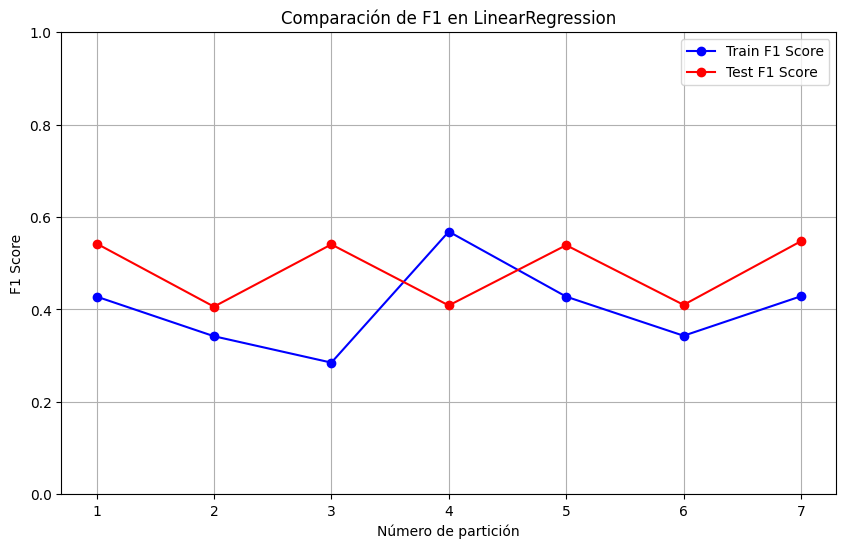

In [31]:
plot_results('LinearRegression')

### Regresión Polinomial DONE

##### Entrenamiento

Tenemos un problema ya que la matriz generada por aumentar el grado de los datos es demasiado grande aunque sea simplemente de grado 2.

Debido al tamaño del dataframe no podemos utilizar SVC así que intentaré aplicar un PCA y ver con cuántas columnas me quedo

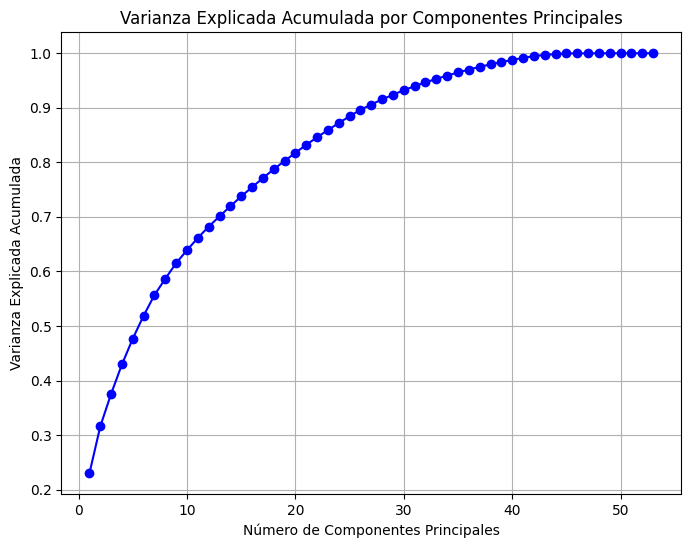

El número óptimo de componentes es 33


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler

pca = IncrementalPCA(n_components=53) 
scaler = StandardScaler()

explained_variance_ratio = []  

for i in range(1, 8):
    df_part = globals()[f'df_train_{i}']
    X_part = df_part.drop(columns=['label'])  
    X_train_scaled = scaler.fit_transform(X_part) if i == 1 else scaler.transform(X_part)  # Escalar
    
    pca.partial_fit(X_train_scaled)
    
    explained_variance_ratio.append(pca.explained_variance_ratio_)

total_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(total_explained_variance) + 1), total_explained_variance, marker='o', color='b')
plt.title('Varianza Explicada Acumulada por Componentes Principales')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.grid(True)
plt.show()

# Puedes elegir cuántos componentes usar basado en la varianza explicada acumulada
# Por ejemplo, si deseas que se explique al menos el 95% de la varianza
n_components_opt = np.argmax(total_explained_variance >= 0.95) + 1  # Primer componente que llega al 95%
print(f"El número óptimo de componentes es {n_components_opt}")


In [43]:
# Generar un dataframes pca
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
n_components = 33  

pca = PCA(n_components=n_components)

for i in range(1,8):
    data_train = globals()[f'df_train_{i}']
    X_train = data_train.drop(columns=['label']).values
    y_train = data_train['label'].values    

    data_test = globals()[f'df_test_{i}']
    X_test = data_test.drop(columns=['label']).values
    y_test = data_test['label'].values

    
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)


    # Lo guardo en un DataFrame para usarlo luego
    data_train_pca = pd.DataFrame(data=X_train_pca, columns=[f'PC{i}' for i in range(1, n_components+1)])
    data_train_pca['label'] = y_train
    globals()[f'df_train_{i}_pca'] = data_train_pca

    data_test_pca = pd.DataFrame(data=X_test_pca, columns=[f'PC{i}' for i in range(1, n_components+1)])
    data_test_pca['label'] = y_test
    globals()[f'df_test_{i}_pca'] = data_test_pca

In [6]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

degree = 2   # ESTE DATO TENEMOS QUE AJUSTARLO (define el grado del polinomio)

model = SGDRegressor(max_iter=1, tol=None, warm_start=True)

poly = PolynomialFeatures(degree)
scaler = StandardScaler()

for i in range(1, 8):
    data_train = globals()[f'df_train_{i}_pca']
    X_train = data_train.drop(columns=['label']).values
    y_train = data_train['label'].values

    X_train_poly = poly.fit_transform(X_train)  
    if i == 1:
        X_train_scaled = scaler.fit_transform(X_train_poly)  
    else:
        X_train_scaled = scaler.transform(X_train_poly) 
        
    model.partial_fit(X_train_scaled, y_train)


In [7]:
dir = "../data/models"
model_path = os.path.join(dir, "PolinomialRegression.joblib")
joblib.dump(model, model_path)

['../data/models\\PolinomialRegression.joblib']

##### Predicción

In [31]:
# Cargar modelo de LogisticRegression
model = joblib.load("../data/models/PolinomialRegression.joblib")

In [44]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

degree = 2   
poly = PolynomialFeatures(degree)
scaler = StandardScaler()


for i in range(1, 8):
    data_train = globals()[f'df_train_{i}_pca']
    X_train = data_train.drop(columns=['label']).values
    y_train = data_train['label'].values

    data_test = globals()[f'df_test_{i}_pca']
    X_test = data_test.drop(columns=['label']).values
    y_test = data_test['label'].values

    X_test_poly = poly.fit_transform(X_test)
    X_train_poly = poly.fit_transform(X_train)  
    if i == 1:
        X_train_scaled = scaler.fit_transform(X_train_poly)  
        X_test_scaled = scaler.fit_transform(X_test_poly)
    else:
        X_train_scaled = scaler.transform(X_train_poly) 
        X_test_scaled = scaler.transform(X_test_poly)

    data_train_poly = pd.DataFrame(data=X_train_scaled)
    data_train_poly['label'] = y_train
    globals()[f'df_train_{i}_pca_poly'] = data_train_poly

    data_test_poly = pd.DataFrame(data=X_test_scaled)
    data_test_poly['label'] = y_test
    globals()[f'df_test_{i}_pca_poly'] = data_test_poly


In [51]:
prediction(model, 'PolinomialRegression')

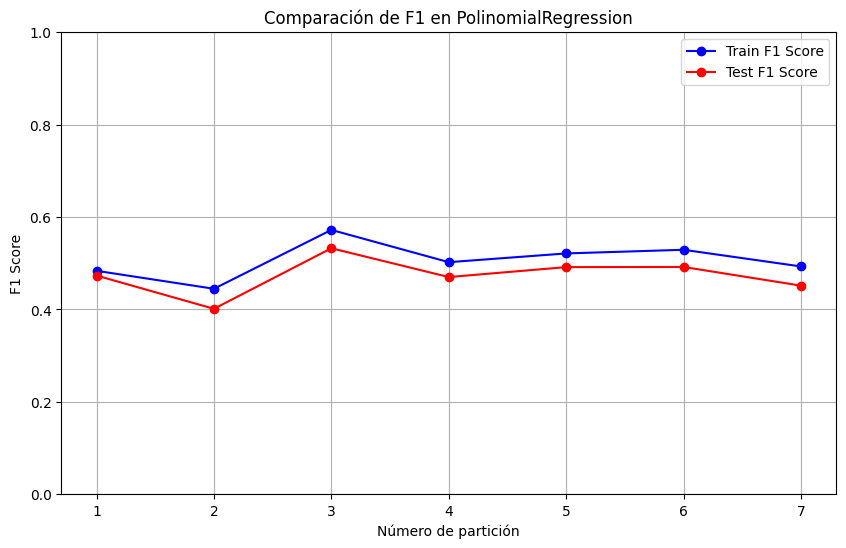

In [52]:
plot_results('PolinomialRegression')

### Regresión Logística: DONE

##### Entrenamiento

Como LinearRegression no permite un entrenamiento por partes, usamos SGDClasifier en su lugar con "loss='log'" para realizar una clasificación utilizando el algoritmo de gradiente descendente estocástico.

In [24]:
model = SGDClassifier(loss='log_loss', random_state=42)

for i in range(1, 8):
    data_train = globals()[f'df_train_{i}']
    X_train = data_train.drop(columns=['label']).values
    y_train = data_train['label'].values

    model.partial_fit(X_train, y_train, classes=np.unique(y_train))


In [25]:
dir = "../data/models"
model_path = os.path.join(dir, "LogisticRegression.joblib")
joblib.dump(model, model_path)


['../data/models\\LogisticRegression.joblib']

##### Predicción

In [53]:
# Cargar modelo de LogisticRegression
model = joblib.load("../data/models/LogisticRegression.joblib")

In [54]:
prediction(model, 'LogisticRegression')

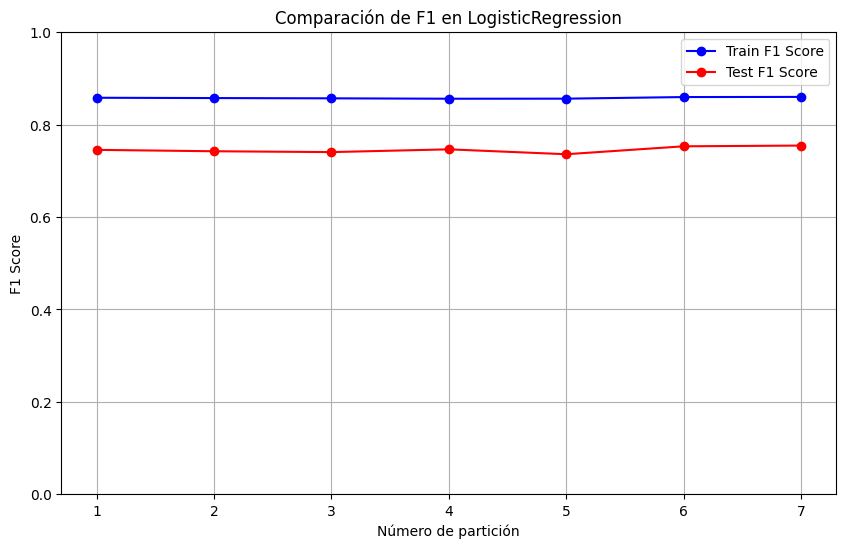

In [55]:
plot_results('LogisticRegression')

### Árboles de decisión: DONE

##### Entrenamiento

El árbol de decisión ha sido capáz de entrenar con todos los datos juntos

<i>"Para la clasificación con pocas clases, min_samples_leaf=1 suele ser la mejor opción.
"</i>
<br> <br><i>"Podemos empezar con min_muestras_hoja=5 como valor inicial. Si el tamaño de la muestra varía mucho, se puede utilizar un número flotante como
porcentaje en estos dos parámetros."</i>

In [9]:

X_train_full = np.vstack([globals()[f'df_train_{i}'].drop(columns=['label']).values for i in range(1, 8)])
y_train_full = np.hstack([globals()[f'df_train_{i}']['label'].values for i in range(1, 8)])

model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=1)
model.fit(X_train_full, y_train_full)

DecisionTreeClassifier(max_depth=3)

In [14]:
dir = "../data/models"
model_path = os.path.join(dir, "DecisionTree.joblib")
joblib.dump(model, model_path)

['../data/models\\DecisionTree.joblib']

##### Predicción

In [15]:
# Cargar modelo de LogisticRegression
model = joblib.load("../data/models/DecisionTree.joblib")

In [16]:
prediction(model, 'DecisionTree')

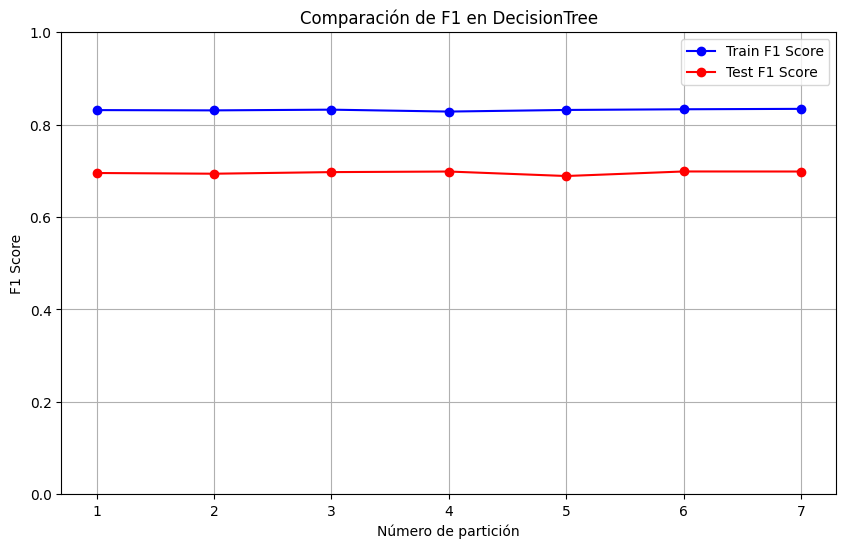

In [17]:
plot_results('DecisionTree')

### Basado en instancias : KNN -> DONE? (solo con una partición pequeña)

##### Entrenamiento

He intentado con annoy (según la documentación, permite aproximar KNN con un enfoque eficiente en memoria) pero el kernel muere intentando entrenarlo

Como no sirve nada, voy a coger una muestra pequeña representativa y voy a entrenar el modelo con ella

In [19]:
import pandas as pd

# Definir el tamaño de la muestra (1% en este ejemplo)
sample_fraction = 0.01  # Ajusta esto según tus necesidades

# DataFrames particionados de tus datos, aquí simulados como lista
partitions = [globals()[f'df_train_{i}'] for i in range(1, 8)]

# Crear lista para almacenar las muestras
sampled_data = []

# Iterar sobre cada partición y tomar una muestra estratificada
for df in partitions:
    sampled_df = df.groupby('label', as_index=False).apply(
        lambda x: x.sample(frac=sample_fraction, random_state=42)
    ).reset_index(drop=True)  # Eliminar índice adicional
    sampled_data.append(sampled_df)

# Concatenar todas las muestras para tener un único DataFrame de muestra
final_sample = pd.concat(sampled_data, ignore_index=True)

# Confirmación de la muestra final y de que 'label' está presente
print("Tamaño de la muestra final:", final_sample.shape)


C:\Users\eleni\AppData\Local\Temp\ipykernel_3320\2424558243.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('label', as_index=False).apply(
C:\Users\eleni\AppData\Local\Temp\ipykernel_3320\2424558243.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('label', as_index=False).apply(
C:\Users\eleni\AppData\Local\Temp\ipykernel_3320\2424558243.py:14: Depre

Tamaño de la muestra final: (39182, 55)


C:\Users\eleni\AppData\Local\Temp\ipykernel_3320\2424558243.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('label', as_index=False).apply(
C:\Users\eleni\AppData\Local\Temp\ipykernel_3320\2424558243.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('label', as_index=False).apply(


In [18]:
print(final_sample.columns)


Index(['ID', 'Payment_6804', 'Infraction_CGP', 'Base_7744', 'Base_80863',
       'Risk_1930', 'Infraction_SNZ', 'Base_02683', 'Infraction_QJJF',
       'Base_76065', 'Risk_0322', 'Infraction_GGO', 'Base_39598', 'Base_6187',
       'Base_85131', 'Risk_9995', 'Infraction_AYWV', 'Base_36384',
       'Base_24406', 'Infraction_BSU', 'Infraction_ZYW', 'Base_1039',
       'Base_0580', 'Expenditure_RGD', 'Base_69608', 'Base_6852', 'Base_22178',
       'Infraction_ZTYG', 'Expenditure_UWVG', 'Base_3041', 'Payment_3207',
       'Infraction_QKZN', 'Infraction_CZE', 'Base_66195', 'Risk_4553',
       'Base_67585', 'Infraction_HFSI', 'Infraction_ETH', 'Base_2810',
       'Risk_8902', 'Infraction_BGGU', 'Infraction_NMCB', 'Infraction_XEPQ',
       'Infraction_ZMKI', 'Infraction_RKTA', 'Infraction_SIA',
       'Infraction_QEY', 'Infraction_VHHP', 'Infraction_LIES',
       'Infraction_QWWW', 'Infraction_YQXM', 'Infraction_QGR',
       'Infraction_LSX', 'Expenditure_AHF_year', 'label'],
      dtype='obje

In [20]:
# Entrenar un modelo de KNN con final_sample
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
X = final_sample.drop(columns=['label']).values
y = final_sample['label'].values
model.fit(X, y)

KNeighborsClassifier()

In [22]:
dir = "../data/models"
model_path = os.path.join(dir, "KNN.joblib")
joblib.dump(model, model_path)


['../data/models\\KNN.joblib']

##### Predicción

In [59]:
model = joblib.load("../data/models/KNN.joblib")

In [60]:
prediction(model, 'KNN')

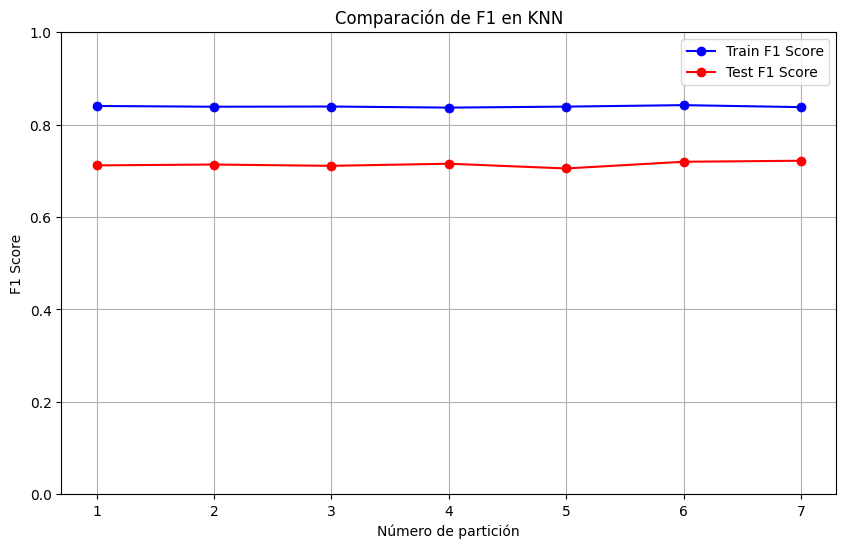

In [61]:
plot_results('KNN')

### Máquinas de soporte vectorial : SVC

##### Entrenamiento

Son sensibles a la escala de datos, por suerte, los datos han sido escalados en el preproceso

Existen varios kernel para el SVC: "
- linear: para usar un kernel lineal.
- poly: para usar un kernel polinomial.
- rbf: para usar un kernel de función de base radial.
- sigmoid: para usar un kernel sigmoidal.
- precomputed: para proporcionar una matriz de kernel precomputada."
<br><br>Como SVC no tiene partial_fit(), vamos a intentar usar SGDClassifier con loss="hinge" para simular un SVM lineal

In [26]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np

model = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3)

scaler = StandardScaler()

for i in range (1, 8):
    
    df_part = globals()[f'df_train_{i}'] 
    X_part = df_part.drop(columns=['label'])  
    y_part = df_part['label']
    X_train_scaled = scaler.fit_transform(X_part) if i == 1 else scaler.transform(X_part)
    
    model.partial_fit(X_train_scaled, y_part, classes=np.unique(y_part))


In [27]:
dir = "../data/models"
model_path = os.path.join(dir, "SVM_linearSGD.joblib")
joblib.dump(model, model_path)


['../data/models\\SVM_linearSGD.joblib']

Hemos intentado hacer un PCA previo a la ejecución de SVC pero este modelo necesita toda la información así que hemos optado por probar entrenarlo solo con una partición

In [39]:
# KERNEL KILLER


# from sklearn.decomposition import PCA
# from sklearn.svm import SVC
# from sklearn.preprocessing import StandardScaler
# import pandas as pd

# scaler = StandardScaler()
# pca = PCA(n_components=33)

# df = df_train_1

# X = df.drop('label', axis=1)  
# y = df['label']  

# X_train_scaled = scaler.fit_transform(X)  

# X_pca = pca.fit_transform(X_train_scaled) 



# svc = SVC(kernel='linear', random_state=42, verbose=True)
# svc.fit(X_pca, y)


[LibSVM]

: 

##### Predicción

In [63]:
model = joblib.load("../data/models/SVM_linearSGD.joblib")

In [64]:
prediction(model, 'SVM_linearSGD')

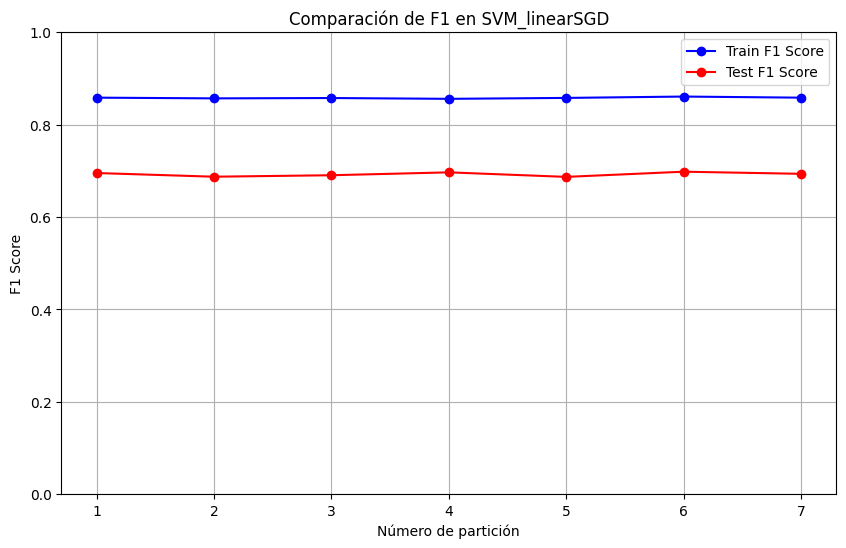

In [65]:
plot_results('SVM_linearSGD')

### Redes neuronales : DONE

In [ ]:
!pip3.12 install tensorflow


In [19]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def create_model(input_shape):
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Salida para clasificación binaria
    ])
    return model

input_shape = globals()['df_train_1'].shape[1] - 1  # -1 para excluir la columna 'label'
model = create_model(input_shape)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo usando cada partición secuencialmente
epochs = 50
batch_size = 512

early_stopping = EarlyStopping(
    monitor='loss',  # monitor the validation loss
    patience=3,          # stop if no improvement for 3 consecutive epochs
    restore_best_weights=True  # revert to the best weights at the end
)

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    for i in range(1, 8):  
        data_train = globals()[f'df_train_{i}']
        X_train = data_train.drop(columns=['label']).values
        y_train = data_train['label'].values

        # Entrenar el modelo en esta partición de datos
        model.fit(X_train, y_train, epochs=1, batch_size=batch_size, callbacks=[early_stopping], verbose=1)



Epoch 1/50
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8140 - loss: 0.4235
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8606 - loss: 0.3518
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8620 - loss: 0.3418
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8594 - loss: 0.3427
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8619 - loss: 0.3385
1155/1155 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8658 - loss: 0.3317
741/741 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8640 - loss: 0.3360
Epoch 2/50
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8641 - loss: 0.3352
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8618 - loss: 0.3408
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8633 - loss: 0.3363
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8613 - loss: 0.3373
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8639 - loss: 0.3339
1155/1155 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0

In [20]:
dir = "../data/models"
model_path = os.path.join(dir, "Neural_network.joblib")
joblib.dump(model, model_path)

['../data/models\\Neural_network.joblib']

##### Predicción

In [21]:
model = joblib.load("../data/models/Neural_network.joblib")

In [27]:
prediction(model, 'Neural_network')

18416/18416 ━━━━━━━━━━━━━━━━━━━━ 9s 474us/step
3074/3074 ━━━━━━━━━━━━━━━━━━━━ 1s 457us/step
18489/18489 ━━━━━━━━━━━━━━━━━━━━ 9s 472us/step
3068/3068 ━━━━━━━━━━━━━━━━━━━━ 2s 523us/step
18380/18380 ━━━━━━━━━━━━━━━━━━━━ 9s 495us/step
3058/3058 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step
18416/18416 ━━━━━━━━━━━━━━━━━━━━ 8s 449us/step
3077/3077 ━━━━━━━━━━━━━━━━━━━━ 2s 540us/step
18426/18426 ━━━━━━━━━━━━━━━━━━━━ 10s 551us/step
3079/3079 ━━━━━━━━━━━━━━━━━━━━ 2s 531us/step
18473/18473 ━━━━━━━━━━━━━━━━━━━━ 9s 477us/step
3069/3069 ━━━━━━━━━━━━━━━━━━━━ 2s 528us/step
11850/11850 ━━━━━━━━━━━━━━━━━━━━ 7s 548us/step
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 1s 450us/step


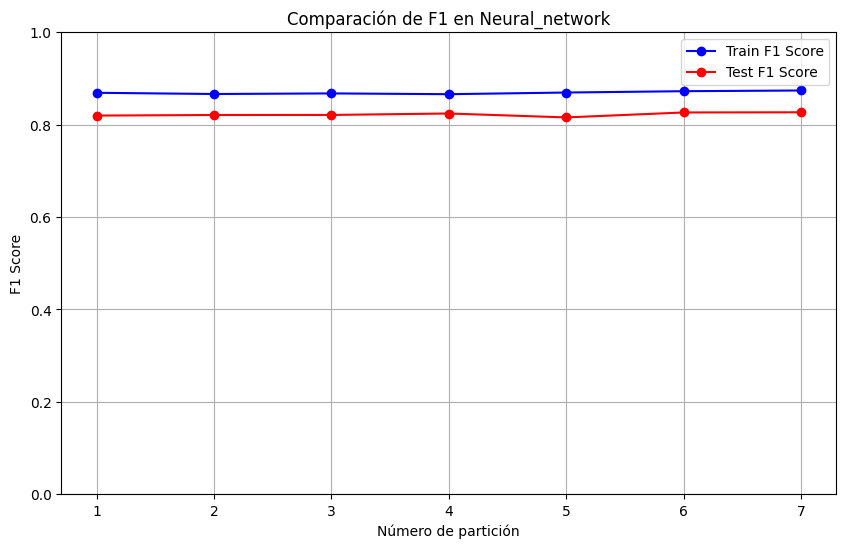

In [28]:
plot_results('Neural_network')

# Comparación de resultados

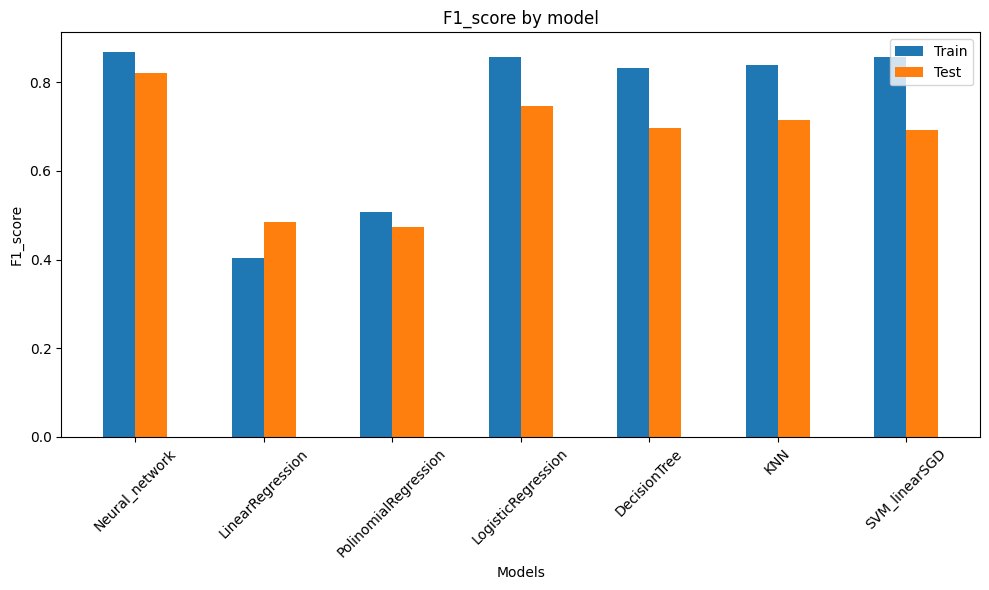

In [66]:
plot_model_comparison(models_results, metric='f1_score')

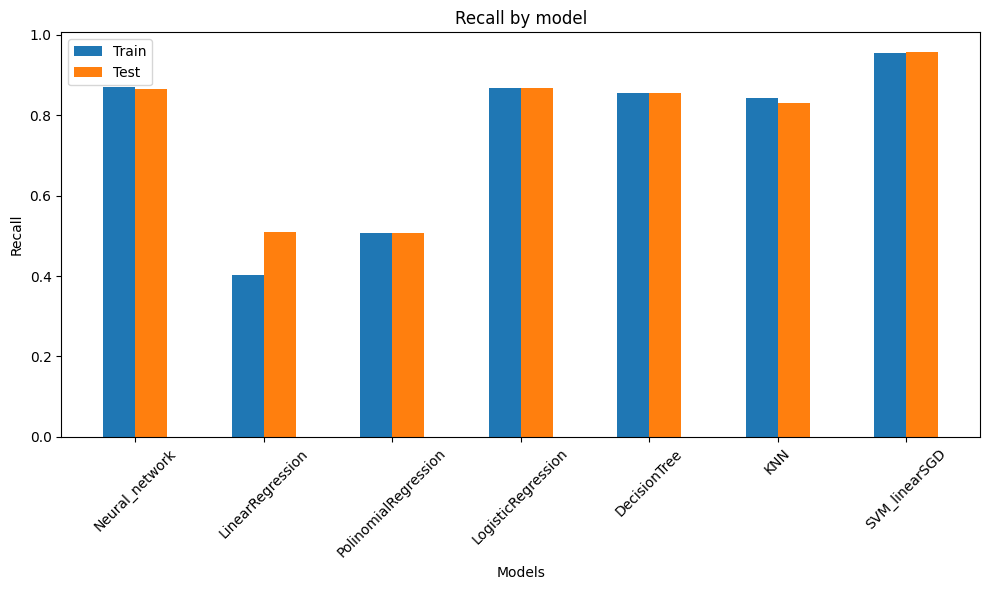

In [67]:
plot_model_comparison(models_results, metric='recall')

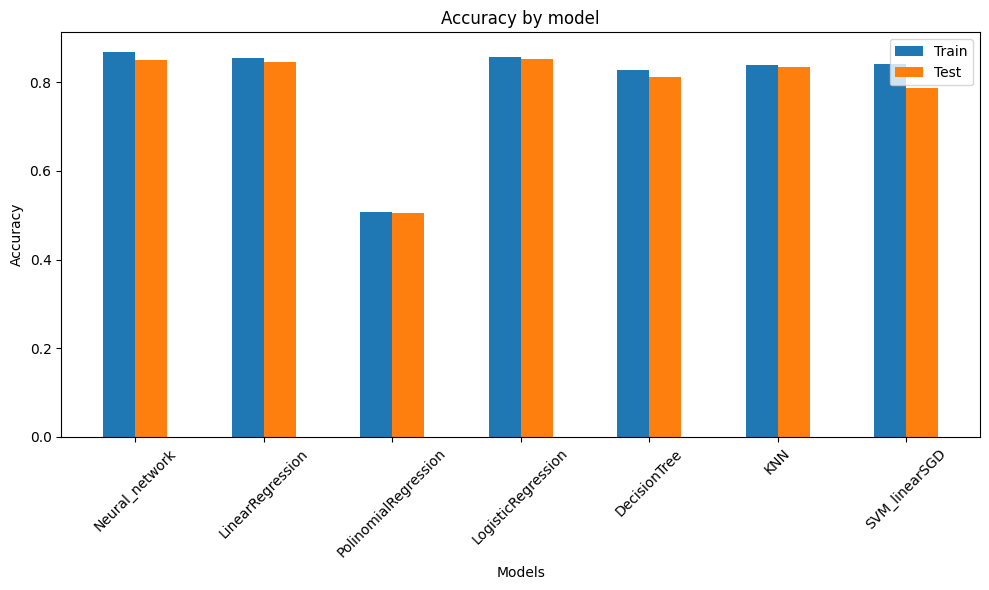

In [68]:
plot_model_comparison(models_results)

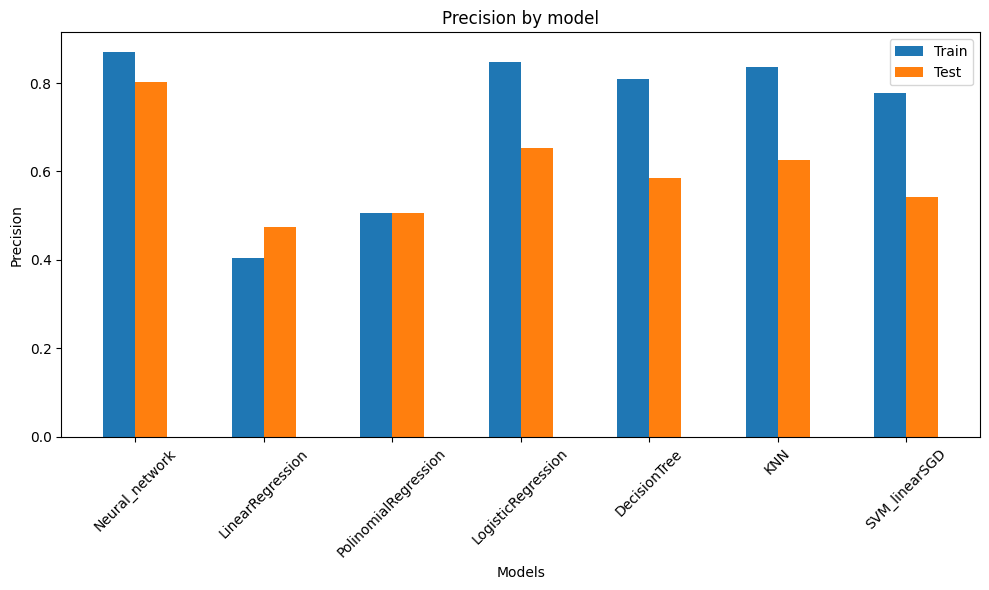

In [69]:
plot_model_comparison(models_results, metric='precision')

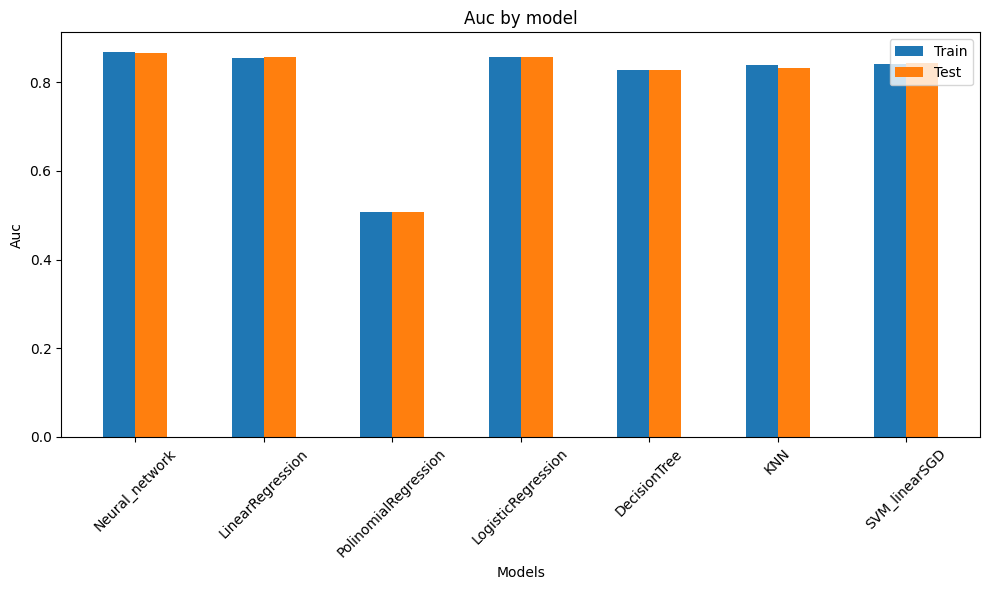

In [ ]:
plot_model_comparison(models_results, metric='auc')

# Ajuste de hiperparámetros

### RandomisedSearch

- Los mejores parametros para LinearRegression: {'alpha': 0.037554011884736255, 'eta0': 0.9517143064099162, 'penalty': 'elasticnet'}
- Los mejores parametros para PolynomialRegression: {'alpha': 0.037554011884736255, 'eta0': 0.9517143064099162, 'penalty': 'elasticnet'}
- Los mejores parametros LogisticRegression: {'alpha': 0.09666320330745594, 'eta0': 0.8093973481164611, 'penalty': 'l2'}
- Los mejores parametros para DecisionTreeClassifier: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 5}
- Los mejores parametros para KNeighborsClassifier: {'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}
- Los mejores parámetros para SVC: {'alpha': 0.00694233026512157, 'max_iter': 3000, 'penalty': 'elasticnet', 'tol': 0.001}

#### Regresión Lineal

In [ ]:
from sklearn.model_selection import RandomizedSearchCV


In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import joblib
import numpy as np

param_dist_linear = {
    'alpha': uniform(1e-4, 1e-1),
    'penalty': ['l2', 'l1', 'elasticnet'],
    'eta0': uniform(1e-3, 1.0)
}

model = joblib.load("../data/models/LinearRegression.joblib")

scores = []

for i in range(1, 8):
    data_train = globals()[f'df_train_{i}']
    X_train = data_train.drop(columns=['label']).values
    y_train = data_train['label'].values
    
    search = RandomizedSearchCV(model, param_distributions=param_dist_linear, n_iter=20, scoring='f1_weighted', n_jobs=-1, cv=3, random_state=42)
    search.fit(X_train, y_train)
    
    scores.append(search.best_score_)

# X_train = df_train_1.drop(columns=['label']).values
# y_train = df_train_1['label'].values

# search = RandomizedSearchCV(model, param_distributions=param_dist_linear, n_iter=20, cv=3, random_state=42, scoring='f1_weighted', n_jobs=-1)
# search.fit(X_train, y_train)
    
# scores.append(search.best_score_)


avg_score = np.mean(scores)
#print("Average error para LinearRegression:", -avg_score)
print("Los mejores parametros para LinearRegression:", search.best_params_)


c:\Users\48726\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SGDRegressor from version 1.5.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\48726\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(
c:\Users\48726\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(
c:\Users\48726\AppData\Local

Los mejores parametros para LinearRegression: {'alpha': 0.037554011884736255, 'eta0': 0.9517143064099162, 'penalty': 'elasticnet'}


#### Regresión Polynomial

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from scipy.stats import randint

param_dist_poly = {
    'alpha': uniform(1e-4, 1e-1),
    'penalty': ['l2', 'l1', 'elasticnet'],
    'eta0': uniform(1e-3, 1.0),
}
model = joblib.load("../data/models/PolinomialRegression.joblib")
scores = []

for i in range(1, 8):
    data_train = globals()[f'df_train_{i}']
    X_train = data_train.drop(columns=['label']).values
    y_train = data_train['label'].values
    
    search = RandomizedSearchCV(model, param_distributions=param_dist_poly, n_iter=20, cv=3, random_state=42, scoring='f1_weighted', n_jobs=-1)
    search.fit(X_train, y_train)
    scores.append(search.best_score_)

# X_train = df_train_1.drop(columns=['label']).values
# y_train = df_train_1['label'].values

# search = RandomizedSearchCV(model, param_distributions=param_dist_poly, n_iter=20, cv=3, random_state=42, scoring='f1_weighted', n_jobs=-1)
# search.fit(X_train, y_train)
# scores.append(search.best_score_)


# avg_score = np.mean(scores)
# print("Average error para PolynomialRegression:", -avg_score)
print("Los mejores parametros para PolynomialRegression:", search.best_params_)


c:\Users\48726\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(
c:\Users\48726\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(
c:\Users\48726\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(
c:\Users\48726\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan

Los mejores parametros para PolynomialRegression: {'alpha': 0.037554011884736255, 'eta0': 0.9517143064099162, 'penalty': 'elasticnet'}


#### Regresión Logistica

In [ ]:
from sklearn.linear_model import LogisticRegression

param_dist_logistic = {
    'alpha': uniform(1e-4, 1e-1),
    'penalty': ['l2', 'l1', 'elasticnet'],
    'eta0': uniform(1e-3, 1.0),
}

model = joblib.load("../data/models/LogisticRegression.joblib")

scores = []

for i in range(1, 8):
    data_train = globals()[f'df_train_{i}']
    X_train = data_train.drop(columns=['label']).values
    y_train = data_train['label'].values

    search = RandomizedSearchCV(model, param_distributions=param_dist_logistic, n_iter=20, scoring='f1_weighted', n_jobs=-1, cv=3, random_state=42)
    search.fit(X_train, y_train)
    scores.append(search.best_score_)

avg_score = np.mean(scores)
#print("El mejor accuracy LogisticRegression:", avg_score)
print("Los mejores parametros LogisticRegression:", search.best_params_)


c:\Users\48726\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SGDClassifier from version 1.5.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


El mejor accuracy LogisticRegression: 0.8419888579510932
Los mejores parametros LogisticRegression: {'alpha': 0.09666320330745594, 'eta0': 0.8093973481164611, 'penalty': 'l2'}


#### Decission Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from scipy.stats import randint

param_dist_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2'],
}

model = joblib.load("../data/models/DecisionTree.joblib")

scores = []

for i in range(1, 8):
    data_train = globals()[f'df_train_{i}']
    X_train = data_train.drop(columns=['label']).values
    y_train = data_train['label'].values

    search = RandomizedSearchCV(model, param_distributions=param_dist_tree, n_iter=20,  scoring='f1_weighted', n_jobs=-1, cv=2, random_state=42)
    search.fit(X_train, y_train)
    scores.append(search.best_score_)

# X_train = df_train_1.drop(columns=['label']).values 
# y_train = df_train_1['label'].values

# search = RandomizedSearchCV(model, param_distributions=param_dist_tree, n_iter=20,  scoring='f1_weighted', n_jobs=-1, cv=2, random_state=42)
# search.fit(X_train, y_train)
# scores.append(search.best_score_)


avg_score = np.mean(scores)
#print("El mejor accuracy para DecisionTreeClassifier:", avg_score)
print("Los mejores parametros para DecisionTreeClassifier:", search.best_params_)


Los mejores parametros para DecisionTreeClassifier: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 5}


#### KNN

Intente a usar una muestra, como hemos hecho antes. He probado 1000, 2000 y 10000 filas. Despues intente a hacer 10% (58000  filas), pero no se ejecuta. Entonces dejo 10000.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import joblib
import numpy as np

# Parche del modelo
model = joblib.load("../data/models/KNN.joblib")

param_dist_knn = {
    'n_neighbors': randint(1, 10),  # Rango reducido para acelerar
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

scores = []

# for i in range(1, 8):
#     data_train = globals()[f'df_train_{i}']
#     X_train = data_train.drop(columns=['label']).values
#     y_train = data_train['label'].values

#     search = RandomizedSearchCV(model, param_distributions=param_dist_knn, n_iter=20,  scoring='f1_weighted', n_jobs=-1, cv=3, random_state=42)
#     search.fit(X_train, y_train)
#     scores.append(search.best_score_)


# Selección de muestra de datos o reducción de pliegues de validación cruzada
X_train = df_train_1.drop(columns=['label']).values[:10000] # Usar muestra si es posible
y_train = df_train_1['label'].values[:10000]

# Aplicar RandomizedSearchCV
search = RandomizedSearchCV(
    model, param_distributions=param_dist_knn,
    n_iter=10,  # Reducir n_iter
    scoring='f1_weighted',
    n_jobs=-1, 
    cv=2,  # Reducir número de pliegues en validación cruzada
    random_state=42
)

# Ajuste del modelo
search.fit(X_train, y_train)
scores.append(search.best_score_)

# Resultado promedio
avg_score = np.mean(scores)
print("Los mejores parametros para KNeighborsClassifier:", search.best_params_)
print("Promedio F1-Score:", avg_score)

c:\Users\48726\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.5.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Los mejores parametros para KNeighborsClassifier: {'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}
Promedio F1-Score: 0.7980644341754365


para una muestra de 1000 datos:

Los mejores parametros para KNeighborsClassifier: {'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}
Promedio F1-Score: 0.7804016532836001

para una muestra de 3000 datos:  
Los mejores parametros para KNeighborsClassifier: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
Promedio F1-Score: 0.7491107442031882

para una muestra de 10000 datos:
Los mejores parametros para KNeighborsClassifier: {'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}
Promedio F1-Score: 0.7980644341754365

#### SVC

In [ ]:
from sklearn.linear_model import SGDClassifier
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
import joblib
import numpy as np

param_dist_sgd = {
    'alpha': uniform(0.0001, 0.01),  # Regularización
    'penalty': ['l2', 'l1', 'elasticnet'],
    'max_iter': [1000, 2000, 3000],  # Número de iteraciones
    'tol': [1e-3, 1e-4, 1e-5]  # Tolerancia
}

model = joblib.load("../data/models/SVM_linearSGD.joblib")

scores = []

for i in range(1, 8):
    data_train = globals()[f'df_train_{i}']
    X_train = data_train.drop(columns=['label']).values
    y_train = data_train['label'].values

    search = RandomizedSearchCV(
        model,
        param_distributions=param_dist_sgd,
        n_iter=20,
        scoring='f1_weighted',
        n_jobs=-1,
        cv=3,
        random_state=42
    )
    search.fit(X_train, y_train)
    scores.append(search.best_score_)

avg_score = np.mean(scores)

print("El mejor F1-Score promedio para SGDClassifier:", avg_score)
print("Los mejores parámetros para SGDClassifier:", search.best_params_)


c:\Users\48726\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SGDClassifier from version 1.5.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


El mejor F1-Score promedio para SGDClassifier: 0.8363456623479586
Los mejores parámetros para SGDClassifier: {'alpha': 0.00694233026512157, 'max_iter': 3000, 'penalty': 'elasticnet', 'tol': 0.001}


#### Redes Neuronales

In [ ]:
##

# Hiperparámetros Elena: Redes neuronales

Si no funciona, este sí que va

In [20]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import ParameterSampler
from scipy.stats import uniform, randint

# Datos de entrada
X_train =  df_train_1.drop(columns=['label']).values  # Asegúrate de que 'label' es el nombre de la columna objetivo

y_train = df_train_1['label'].values

# Función para construir el modelo
def create_model(input_shape, units_1, units_2, dropout_rate, optimizer, learning_rate):
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(units_1, activation='relu'),
        Dropout(dropout_rate),
        Dense(units_2, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')  # Clasificación binaria
    ])
    
    # Configuración del optimizador
    if optimizer == 'adam':
        optim = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optim = SGD(learning_rate=learning_rate)
    else:
        optim = RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Espacio de búsqueda de hiperparámetros
param_dist = {
    'units_1': [64, 128, 256],
    'units_2': [32, 64, 128],
    'dropout_rate': uniform(0.3, 0.5),
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'learning_rate': uniform(1e-4, 1e-2)
}

# Bucle de búsqueda manual
best_accuracy = 0
best_params = None
n_iter = 10  # Número de combinaciones a probar

# Crea muestras aleatorias de combinaciones de hiperparámetros
param_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=0))

for params in param_list:
    print(f"Probando hiperparámetros: {params}")
    
    # Crear y compilar el modelo
    model = create_model(
        input_shape=X_train.shape[1],
        units_1=params['units_1'],
        units_2=params['units_2'],
        dropout_rate=params['dropout_rate'],
        optimizer=params['optimizer'],
        learning_rate=params['learning_rate']
    )

    # Entrenamiento del modelo
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=512,
                        callbacks=[early_stopping], verbose=0)

    # Evaluar el modelo en los datos de validación
    val_accuracy = history.history['val_accuracy'][-1]
    print(f"Precisión de validación: {val_accuracy}")

    # Almacenar los mejores hiperparámetros
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_params = params

print(f"Mejores hiperparámetros: {best_params}")
print(f"Mejor precisión de validación: {best_accuracy}")


Probando hiperparámetros: {'dropout_rate': np.float64(0.5744067519636624), 'learning_rate': np.float64(0.007251893663724195), 'optimizer': 'sgd', 'units_1': 128, 'units_2': 128}
Precisión de validación: 0.8647887110710144
Probando hiperparámetros: {'dropout_rate': np.float64(0.5187936056313462), 'learning_rate': np.float64(0.009017730007820798), 'optimizer': 'adam', 'units_1': 64, 'units_2': 128}
Precisión de validación: 0.886577308177948
Probando hiperparámetros: {'dropout_rate': np.float64(0.5388325586606749), 'learning_rate': np.float64(0.008221687287754931), 'optimizer': 'rmsprop', 'units_1': 64, 'units_2': 64}
Precisión de validación: 0.8665874600410461
Probando hiperparámetros: {'dropout_rate': np.float64(0.7627983191463306), 'learning_rate': np.float64(0.0008103605819788695), 'optimizer': 'sgd', 'units_1': 64, 'units_2': 32}
Precisión de validación: 0.6727812886238098
Probando hiperparámetros: {'dropout_rate': np.float64(0.716309922773969), 'learning_rate': np.float64(0.00788156

In [ ]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Función para crear el modelo con los hiperparámetros de OPTUNA
def create_model(trial, input_shape):
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(trial.suggest_int('neurons_1', 64, 256), activation='relu'),
        Dropout(trial.suggest_float('dropout_1', 0.3, 0.5)),
        Dense(trial.suggest_int('neurons_2', 64, 128), activation='relu'),
        Dropout(trial.suggest_float('dropout_2', 0.3, 0.5)),
        Dense(1, activation='sigmoid')  # Salida para clasificación binaria
    ])
    
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop'])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Función de objetivo de OPTUNA para la optimización
def objective(trial):
    input_shape = globals()['df_train_1'].shape[1] - 1
    model = create_model(trial, input_shape)
    
    # Callback para EarlyStopping
    early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
    
    X_train_full = np.vstack([globals()[f'df_train_{i}'].drop(columns=['label']).values for i in range(1, 8)])
    y_train_full = np.hstack([globals()[f'df_train_{i}']['label'].values for i in range(1, 8)])
    
    # Entrenamiento del modelo
    model.fit(X_train_full, y_train_full, epochs=10, batch_size=512, callbacks=[early_stopping], verbose=1)
    
    # Evaluar el modelo
    loss, accuracy = model.evaluate(X_train_full, y_train_full, verbose=0)
    return accuracy

# Crear un estudio de OPTUNA
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Imprimir los mejores hiperparámetros encontrados
print(f"Best trial: {study.best_trial.params}")


Best trial: {'neurons_1': 255, 'dropout_1': 0.31666966256912804, 'neurons_2': 124, 'dropout_2': 0.3008937986275955, 'optimizer': 'adam'}

# Nuevos resultados

### Regresión Lineal

**Los mejores parametros para LinearRegression: {'alpha': 0.037554011884736255, 'eta0': 0.9517143064099162, 'penalty': 'elasticnet'}**


##### Entrenamiento

In [23]:
model = SGDRegressor(loss='squared_error', random_state=42, alpha=0.037554011884736255, eta0=0.9517143064099162, penalty='elasticnet')

for i in range(1, 8):
    data_train = globals()[f'df_train_{i}']
    X_train = data_train.drop(columns=['label']).values
    y_train = data_train['label'].values
    
    model.partial_fit(X_train, y_train)


In [24]:
dir = "../data/models"
model_path = os.path.join(dir, "new_LinearRegression.joblib")
joblib.dump(model, model_path)

['../data/models\\new_LinearRegression.joblib']

##### Predicción

In [57]:
# Cargar modelo de LinearRegression
model = joblib.load("../data/models/new_LinearRegression.joblib")

In [58]:
prediction(model, 'LinearRegression')

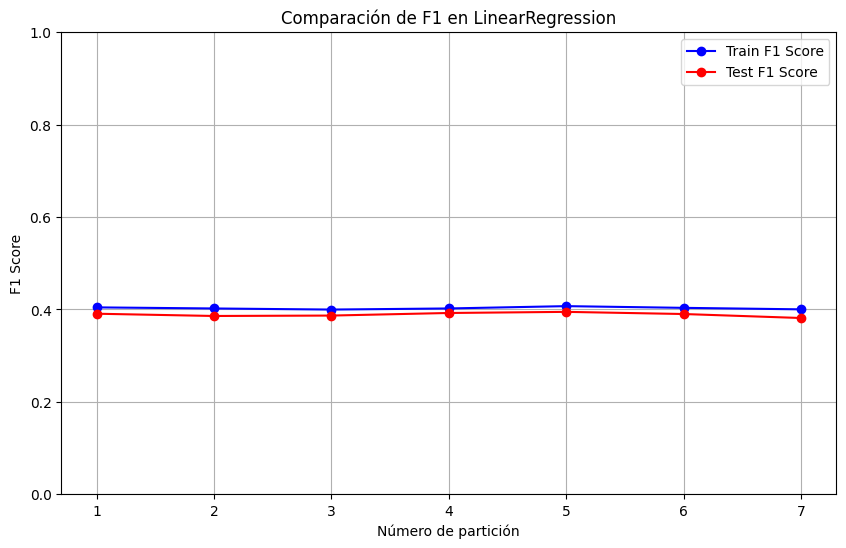

In [59]:
plot_results('LinearRegression')

### Regresión Polinomial

**Los mejores parametros para PolynomialRegression: {'alpha': 0.037554011884736255, 'eta0': 0.9517143064099162, 'penalty': 'elasticnet'}**

##### Entrenamiento

In [63]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

degree = 2 

model = SGDRegressor(max_iter=1, tol=None, warm_start=True, alpha=0.037554011884736255, eta0= 0.9517143064099162, penalty='elasticnet')

poly = PolynomialFeatures(degree)
scaler = StandardScaler()

for i in range(1, 8):
    data_train = globals()[f'df_train_{i}_pca']
    X_train = data_train.drop(columns=['label']).values
    y_train = data_train['label'].values

    X_train_poly = poly.fit_transform(X_train)  
    if i == 1:
        X_train_scaled = scaler.fit_transform(X_train_poly)  
    else:
        X_train_scaled = scaler.transform(X_train_poly) 
        
    model.partial_fit(X_train_scaled, y_train)


In [64]:
dir = "../data/models"
model_path = os.path.join(dir, "new_PolinomialRegression.joblib")
joblib.dump(model, model_path)

['../data/models\\new_PolinomialRegression.joblib']

##### Predicción

In [65]:
# Cargar modelo de LogisticRegression
model = joblib.load("../data/models/new_PolinomialRegression.joblib")

In [67]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


poly = PolynomialFeatures(degree)
scaler = StandardScaler()


for i in range(1, 8):
    data_train = globals()[f'df_train_{i}_pca']
    X_train = data_train.drop(columns=['label']).values
    y_train = data_train['label'].values

    data_test = globals()[f'df_test_{i}_pca']
    X_test = data_test.drop(columns=['label']).values
    y_test = data_test['label'].values

    X_test_poly = poly.fit_transform(X_test)
    X_train_poly = poly.fit_transform(X_train)  
    if i == 1:
        X_train_scaled = scaler.fit_transform(X_train_poly)  
        X_test_scaled = scaler.fit_transform(X_test_poly)
    else:
        X_train_scaled = scaler.transform(X_train_poly) 
        X_test_scaled = scaler.transform(X_test_poly)

    data_train_poly = pd.DataFrame(data=X_train_scaled)
    data_train_poly['label'] = y_train
    globals()[f'df_train_{i}_pca_poly'] = data_train_poly

    data_test_poly = pd.DataFrame(data=X_test_scaled)
    data_test_poly['label'] = y_test
    globals()[f'df_test_{i}_pca_poly'] = data_test_poly


In [68]:
prediction(model, 'PolinomialRegression')

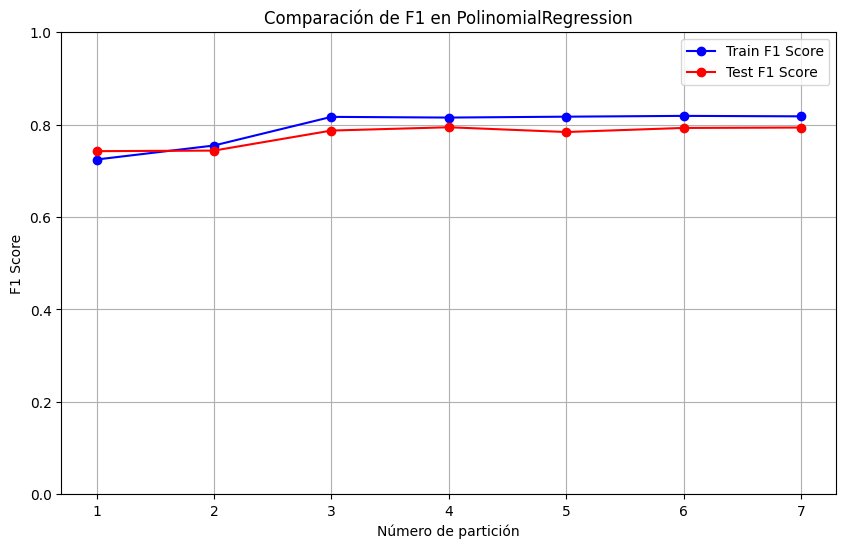

In [69]:
plot_results('PolinomialRegression')

### Regresión Logística:

**Los mejores parametros LogisticRegression: {'alpha': 0.09666320330745594, 'eta0': 0.8093973481164611, 'penalty': 'l2'}**

##### Entrenamiento

In [30]:
model = SGDClassifier(loss='log_loss', random_state=42, alpha=9.144501588851943, penalty='l2')

for i in range(1, 8):
    data_train = globals()[f'df_train_{i}']
    X_train = data_train.drop(columns=['label']).values
    y_train = data_train['label'].values

    model.partial_fit(X_train, y_train, classes=np.unique(y_train))


In [31]:
dir = "../data/models"
model_path = os.path.join(dir, "new_LogisticRegression.joblib")
joblib.dump(model, model_path)


['../data/models\\new_LogisticRegression.joblib']

##### Predicción

In [32]:
# Cargar modelo de LogisticRegression
model = joblib.load("../data/models/new_LogisticRegression.joblib")

In [33]:
prediction(model, 'LogisticRegression')

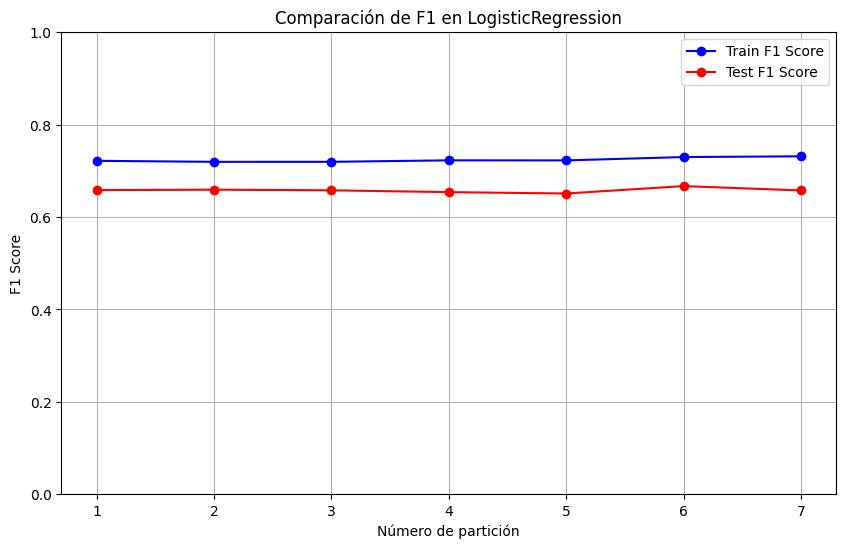

In [34]:
plot_results('LogisticRegression')

<!-- ### Árboles de decisión:  -->

### Árboles de decisión

**Los mejores parametros para DecisionTreeClassifier: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 5}**

##### Entrenamiento

In [35]:

X_train_full = np.vstack([globals()[f'df_train_{i}'].drop(columns=['label']).values for i in range(1, 8)])
y_train_full = np.hstack([globals()[f'df_train_{i}']['label'].values for i in range(1, 8)])
model = DecisionTreeClassifier(criterion= 'gini', max_depth= 4, max_features= 'log2', min_samples_leaf= 7, min_samples_split= 5)
model.fit(X_train_full, y_train_full)


DecisionTreeClassifier(max_depth=4, max_features='log2', min_samples_leaf=7,
                       min_samples_split=5)

In [36]:
dir = "../data/models"
model_path = os.path.join(dir, "new_DecisionTree.joblib")
joblib.dump(model, model_path)

['../data/models\\new_DecisionTree.joblib']

##### Predicción

In [37]:
# Cargar modelo de LogisticRegression
model = joblib.load("../data/models/new_DecisionTree.joblib")

In [38]:
prediction(model, 'DecisionTree')

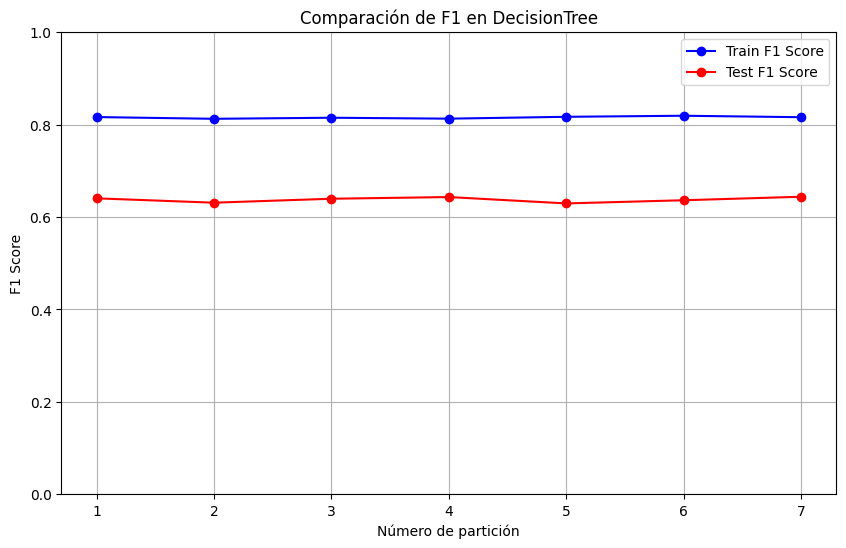

In [39]:
plot_results('DecisionTree')

### Basado en instancias : KNN 

**Los mejores parametros para KNeighborsClassifier: {'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}**

##### Entrenamiento

In [40]:
import pandas as pd

# Definir el tamaño de la muestra (1% en este ejemplo)
sample_fraction = 0.01  # Ajusta esto según tus necesidades

# DataFrames particionados de tus datos, aquí simulados como lista
partitions = [globals()[f'df_train_{i}'] for i in range(1, 8)]

# Crear lista para almacenar las muestras
sampled_data = []

# Iterar sobre cada partición y tomar una muestra estratificada
for df in partitions:
    sampled_df = df.groupby('label', as_index=False).apply(
        lambda x: x.sample(frac=sample_fraction, random_state=42)
    ).reset_index(drop=True)  # Eliminar índice adicional
    sampled_data.append(sampled_df)

# Concatenar todas las muestras para tener un único DataFrame de muestra
final_sample = pd.concat(sampled_data, ignore_index=True)

# Confirmación de la muestra final y de que 'label' está presente
print("Tamaño de la muestra final:", final_sample.shape)


C:\Users\eleni\AppData\Local\Temp\ipykernel_22604\2424558243.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('label', as_index=False).apply(
C:\Users\eleni\AppData\Local\Temp\ipykernel_22604\2424558243.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('label', as_index=False).apply(
C:\Users\eleni\AppData\Local\Temp\ipykernel_22604\2424558243.py:14: De

Tamaño de la muestra final: (39182, 55)


In [41]:
# Entrenar un modelo de KNN con final_sample
from sklearn.neighbors import KNeighborsClassifier
model = model = KNeighborsClassifier(n_neighbors=8, metric='manhattan', weights='distance')
X = final_sample.drop(columns=['label']).values
y = final_sample['label'].values
model.fit(X, y)

KNeighborsClassifier(metric='manhattan', n_neighbors=8, weights='distance')

In [42]:
dir = "../data/models"
model_path = os.path.join(dir, "new_KNN.joblib")
joblib.dump(model, model_path)


['../data/models\\new_KNN.joblib']

##### Predicción

In [43]:
model = joblib.load("../data/models/new_KNN.joblib")

In [44]:
prediction(model, 'KNN')

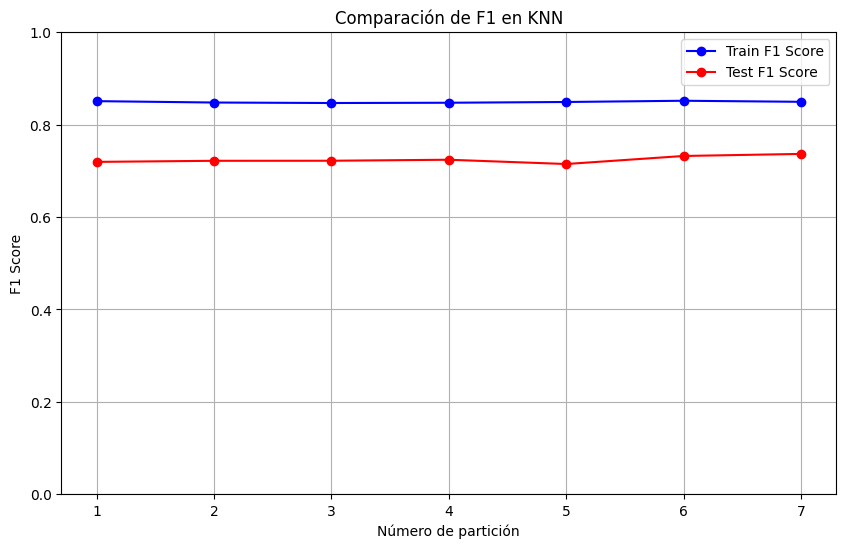

In [45]:
plot_results('KNN')

### Máquinas de soporte vectorial : SVC

**Los mejores parámetros para SVC: {'alpha': 0.00694233026512157, 'max_iter': 3000, 'penalty': 'elasticnet', 'tol': 0.001}**

##### Entrenamiento

In [46]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np

model = SGDClassifier(loss='hinge', alpha= 0.00694233026512157, max_iter= 3000, penalty= 'elasticnet', tol= 0.001)

scaler = StandardScaler()

for i in range (1, 8):
    
    df_part = globals()[f'df_train_{i}'] 
    X_part = df_part.drop(columns=['label'])  
    y_part = df_part['label']
    X_train_scaled = scaler.fit_transform(X_part) if i == 1 else scaler.transform(X_part)
    
    model.partial_fit(X_train_scaled, y_part, classes=np.unique(y_part))


In [47]:
dir = "../data/models"
model_path = os.path.join(dir, "new_SVM_linearSGD.joblib")
joblib.dump(model, model_path)


['../data/models\\new_SVM_linearSGD.joblib']

##### Predicción

In [48]:
model = joblib.load("../data/models/new_SVM_linearSGD.joblib")

In [49]:
prediction(model, 'SVM_linearSGD')

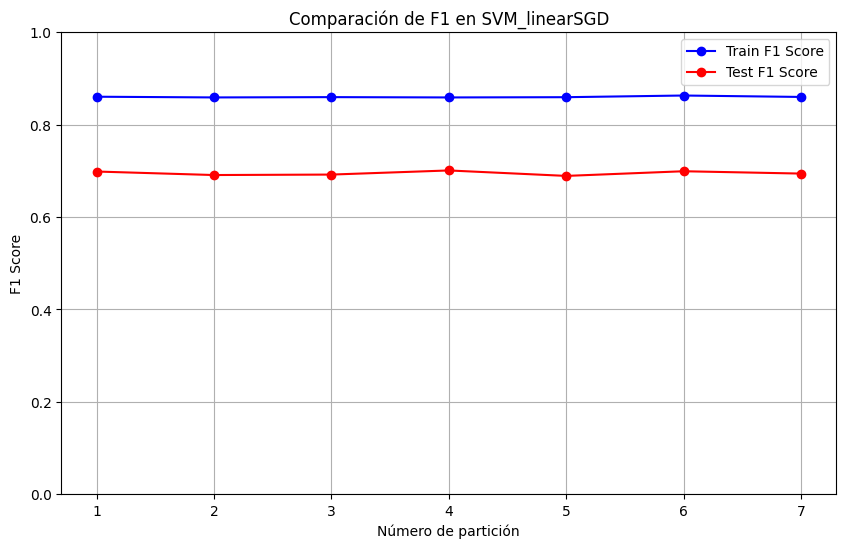

In [50]:
plot_results('SVM_linearSGD')

### Redes neuronales : 

**Los mejores parametros para Neural network:  {'neurons_1': 255, 'dropout_1': 0.31666966256912804, 'neurons_2': 124, 'dropout_2': 0.3008937986275955, 'optimizer': 'adam'}**

##### Entrenamiento

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def create_model(input_shape):
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(255, activation='relu'),
        Dropout( 0.31666966256912804),
        Dense(124, activation='relu'),
        Dropout(0.3008937986275955),
        Dense(1, activation='sigmoid')  # Salida para clasificación binaria
    ])
    return model

input_shape = globals()['df_train_1'].shape[1] - 1  # -1 para excluir la columna 'label'
model = create_model(input_shape)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

epochs = 50
batch_size = 512

early_stopping = EarlyStopping(
    monitor='loss', 
    patience=3,          
    restore_best_weights=True  
)

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    for i in range(1, 8):  
        data_train = globals()[f'df_train_{i}']
        X_train = data_train.drop(columns=['label']).values
        y_train = data_train['label'].values

        model.fit(X_train, y_train, epochs=1, batch_size=batch_size, callbacks=[early_stopping], verbose=1)



Epoch 1/50
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8526 - loss: 0.3466
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8622 - loss: 0.3302
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8650 - loss: 0.3239
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8623 - loss: 0.3258
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8649 - loss: 0.3232
1155/1155 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8694 - loss: 0.3134
741/741 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8659 - loss: 0.3214
Epoch 2/50
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8659 - loss: 0.3216
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8640 - loss: 0.3245
1149/1149 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8669 - loss: 0.3213
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8645 - loss: 0.3220
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8662 - loss: 0.3208
1155/1155 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0

In [22]:
dir = "../data/models"
model_path = os.path.join(dir, "new_Neural_network.joblib")
joblib.dump(model, model_path)

['../data/models\\new_Neural_network.joblib']

##### Predicción

In [51]:
model = joblib.load("../data/models/new_Neural_network.joblib")

In [52]:
prediction(model, 'Neural_network')

18416/18416 ━━━━━━━━━━━━━━━━━━━━ 10s 536us/step
3074/3074 ━━━━━━━━━━━━━━━━━━━━ 2s 523us/step
18489/18489 ━━━━━━━━━━━━━━━━━━━━ 9s 507us/step
3068/3068 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step
18380/18380 ━━━━━━━━━━━━━━━━━━━━ 9s 476us/step
3058/3058 ━━━━━━━━━━━━━━━━━━━━ 2s 523us/step
18416/18416 ━━━━━━━━━━━━━━━━━━━━ 10s 556us/step
3077/3077 ━━━━━━━━━━━━━━━━━━━━ 2s 680us/step
18426/18426 ━━━━━━━━━━━━━━━━━━━━ 14s 757us/step
3079/3079 ━━━━━━━━━━━━━━━━━━━━ 2s 565us/step
18473/18473 ━━━━━━━━━━━━━━━━━━━━ 11s 600us/step
3069/3069 ━━━━━━━━━━━━━━━━━━━━ 2s 562us/step
11850/11850 ━━━━━━━━━━━━━━━━━━━━ 6s 543us/step
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 1s 675us/step


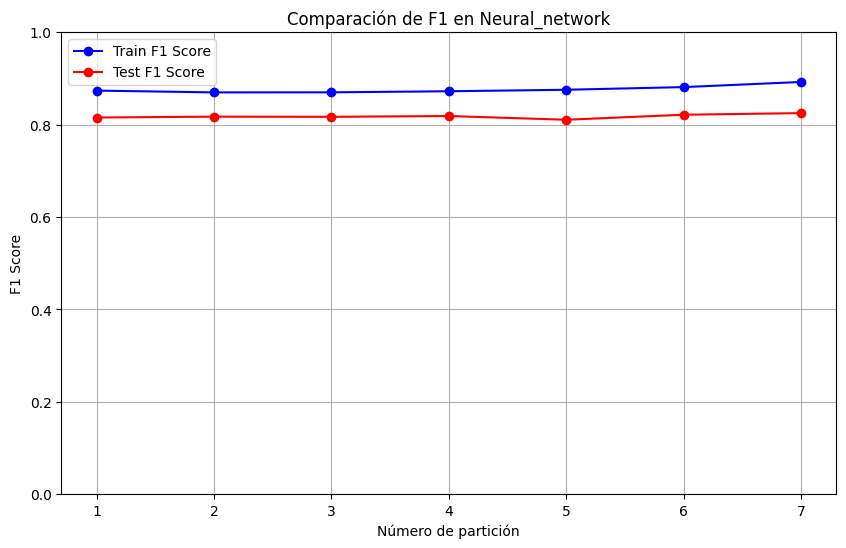

In [53]:
plot_results('Neural_network')

## Segunda Comprobación de resultados

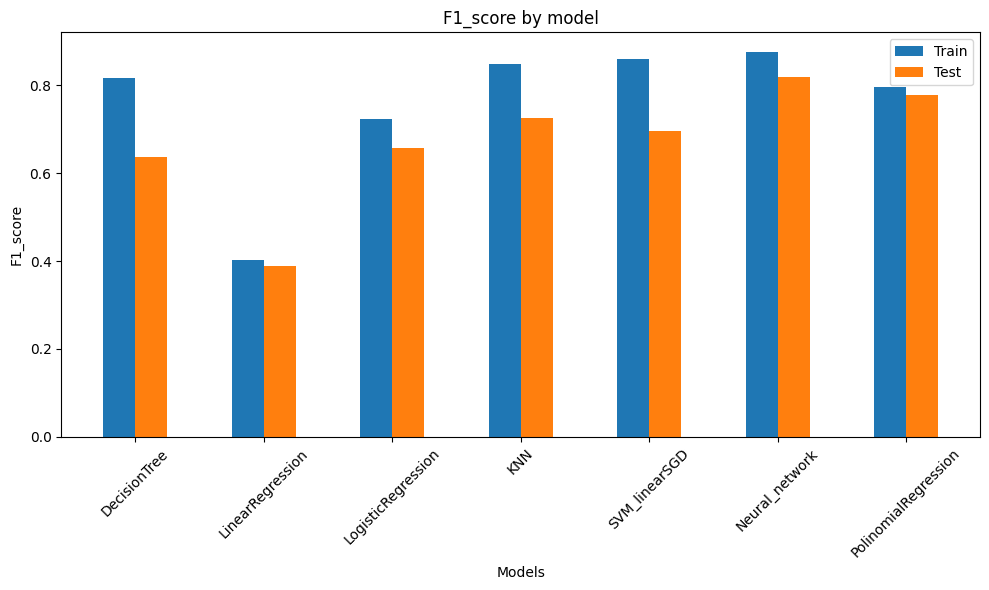

In [70]:
plot_model_comparison(models_results, metric='f1_score')